In [1]:
import os

import pandas as pd
import numpy as np
import sklearn as sk

from scipy import stats
import scipy as sp

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble

import xgboost
from xgboost.sklearn import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.mlab as mlab

import pyodbc
from sqlalchemy import create_engine
from sklearn import preprocessing

import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from collections import Counter
import gensim
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to C:\Users\Sahil
[nltk_data]     Surapaneni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sahil
[nltk_data]     Surapaneni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in '%s': %s" % (cwd, files))

Files in 'C:\Users\Sahil Surapaneni\Train_Data': ['.ipynb_checkpoints', '01_Raw_Data_Retrieval.ipynb', '02_Raw_Data_Update.ipynb', '03-Staging_Data_Exploration.ipynb', '04_Bid&Winner_Prediction_Model.ipynb', '04_Data_Preprocessing.py', '05_Data_Preprocessing.ipynb', '05_Data_Preprocessing.py', '06-TXDOT_Data_Analysis_and_Modeling_Markdown.ipynb', 'df.pkl', 'df_info.pkl', 'estimate_distance_model.sav', 'orig_df.pkl', 'Pictures', 'win_distance_model.sav']


# Removing Unneccesary Cols for Modeling and Changing dtypes

In [3]:
df = pd.read_pickle('df.pkl')

In [7]:
# Dropping columns uneccesary for classification
#Changing data to correct datatype
df['time'] = df['time'].str.extract('(\d+)').astype(int)
temp = df['over/under'].apply(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+",x))
temp.name = 'over/under'
df = df.drop('over/under',axis = 1).join(temp)
df['over/under'] = df['over/under'].str[0]
df['bid'] = df['bid'].astype('int')
df['over/under'] = pd.to_numeric(df['over/under'])
df['misc_cost'] = pd.to_numeric(df['misc_cost'])

df = df[np.isfinite(df['misc_cost'])]

temp = pd.to_datetime(df['let_date'] )
temp = temp.dt.strftime('%Y%m%d')


df['temp'] = pd.DataFrame(temp)
df['temp'] = df['temp'].astype(str)
df['id'] = df['id'].astype(str)
df['id'] = df[['id', 'temp']].apply(lambda x: ''.join(x), axis=1)
df = df.drop(['temp'],axis = 1)

df['proj_low_bid'] ='default value'
temp_1 = df[['bid','id']].drop_duplicates(subset = 'id')
temp_1.head(n=20)
temp_1['bid'].values

low_bid_list = []
for index,row in df.iterrows():
    temp = temp_1[temp_1['id'] == row['id']]['bid']
    low_bid_list.append(temp.item())

df['proj_low_bid'] = low_bid_list

df['distance_from_win'] = (df['bid'] - df['proj_low_bid'])/df['proj_low_bid']
df['distance_from_est'] = (df['bid'] - df['estimate'])/df['estimate']

df['proj_won'] ='default value'
win_list = []
for index,row in df.iterrows():
    if row['bidder'] == row['winning_bidder']:
        win_list.append(1)
    else:
        win_list.append(0)
df['proj_won'] =win_list
df

,index,county,let_date,type,time,highway,length,check,misc_cost,estimate,bid,bidder,winning_bidder,date_accessed,id,over/under,proj_low_bid,distance_from_win,distance_from_est,proj_won
0,0,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,15000.00,10710570.05,9519743,"SBBI, INC.","SBBI, INC.",2019-06-21,305520150505,-11.12,9519743,0.000000,-0.111182,1
1,1,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,15000.00,10710570.05,10089270,"DELHUR INDUSTRIES, INC.","SBBI, INC.",2019-06-21,305520150505,-5.80,9519743,0.059826,-0.058008,0
2,2,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,15000.00,10710570.05,11121238,"REECE ALBERT, INC.","SBBI, INC.",2019-06-21,305520150505,3.83,9519743,0.168229,0.038342,0
3,3,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,15000.00,10710570.05,11698754,"PRICE CONSTRUCTION, LTD.","SBBI, INC.",2019-06-21,305520150505,9.23,9519743,0.228894,0.092262,0
4,4,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,15000.00,10710570.05,13838689,"ALLEN BUTLER CONSTRUCTION, INC.","SBBI, INC.",2019-06-21,305520150505,29.21,9519743,0.453683,0.292059,0
5,5,TRAVIS,2015-11-03,OPERATIONAL IMPROVEMENTS,1000,IH 35,10.529,100000.0,2021524.11,65621781.44,78833226,"OHL USA, INC.","OHL USA, INC.",2019-06-21,300120151103,20.13,78833226,0.000000,0.201327,1
6,6,TRAVIS,2015-11-03,OPERATIONAL IMPROVEMENTS,1000,IH 35,10.529,100000.0,2021524.11,65621781.44,82858565,"MCCARTHY BUILDING COMPANIES, INC.","OHL USA, INC.",2019-06-21,300120151103,26.27,78833226,0.051061,0.262669,0
7,7,TRAVIS,2015-11-03,OPERATIONAL IMPROVEMENTS,1000,IH 35,10.529,100000.0,2021524.11,65621781.44,89592293,THE LANE CONSTRUCTION CORPORATION,"OHL USA, INC.",2019-06-21,300120151103,36.53,78833226,0.136479,0.365283,0
8,8,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,500000.00,35709486.60,32541855,"MARIO SINACOLA & SONS EXCAVATING, INC.","MARIO SINACOLA & SONS EXCAVATING, INC.",2019-06-21,300220151103,-8.87,32541855,0.000000,-0.088706,1
9,9,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,500000.00,35709486.60,32855213,"J.D. ABRAMS, L.P.","MARIO SINACOLA & SONS EXCAVATING, INC.",2019-06-21,300220151103,-7.99,32541855,0.009629,-0.079930,0


In [8]:
df['id']

0        305520150505
1        305520150505
2        305520150505
3        305520150505
4        305520150505
5        300120151103
6        300120151103
7        300120151103
8        300220151103
9        300220151103
10       300220151103
11       300220151103
12       300220151103
13       300220151103
14       300220151103
15       300320161103
16       300320161103
17       300320161103
18       300420161103
19       300420161103
20       300420161103
21       300720161103
22       300720161103
23       300720161103
24       300720161103
25       300720161103
26       300820161103
27       300820161103
28       300820161103
29       300820161103
             ...     
18922    421120190605
18923    421120190605
18924    421120190605
18925    421220190605
18926    421220190605
18927    421220190605
18928    421320190605
18929    421320190605
18930    421320190605
18931    421320190605
18932    421420190605
18933    421420190605
18934    421420190605
18935    421520190605
18936    4

# Outlier Detection and Removal

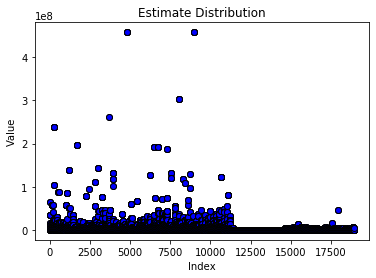

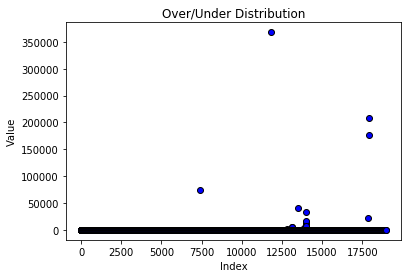

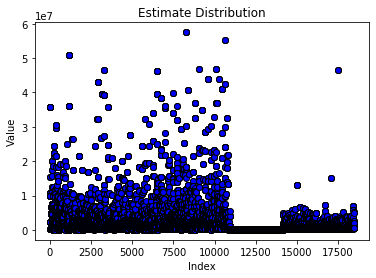

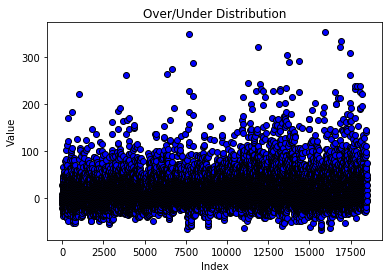

,orig_est,orig_bid
0,10710570.05,9519743
1,10710570.05,10089270
2,10710570.05,11121238
3,10710570.05,11698754
4,10710570.05,13838689
5,35709486.60,32541855
6,35709486.60,32855213
7,35709486.60,33492686
8,35709486.60,33630835
9,35709486.60,33869722


In [9]:
plt.scatter(df.index,df['estimate'].values, color = 'blue', edgecolor = 'black')
plt.title('Estimate Distribution')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

plt.scatter(df.index,df['over/under'].values, color = 'blue', edgecolor = 'black')
plt.title('Over/Under Distribution')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

df = df[((df['over/under'] - df['over/under'].mean()) / df['over/under'].std()).abs() < 3]
df = df[((df['estimate'] - df['estimate'].mean()) / df['estimate'].std()).abs() < 3]
df = df[((df['over/under'] - df['over/under'].mean()) / df['over/under'].std()).abs() < 3]
df = df[((df['misc_cost'] - df['misc_cost'].mean()) / df['misc_cost'].std()).abs() < 3]

df = df.reset_index(drop=True)
df

plt.scatter(df.index,df['estimate'].values, color = 'blue', edgecolor = 'black')
plt.title('Estimate Distribution')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

plt.scatter(df.index,df['over/under'].values, color = 'blue', edgecolor = 'black')
plt.title('Over/Under Distribution')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

orig_df = pd.DataFrame(columns = ['orig_est','orig_bid'])
orig_df['orig_est'] = df['estimate']
orig_df['orig_bid'] = df['bid']
orig_df

# Data Binning

In [10]:
bins = np.linspace(df['estimate'].min(), df['estimate'].max(), 10)
digitized = np.digitize(df['estimate'], bins)

C:\Users\Sahil Surapaneni\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


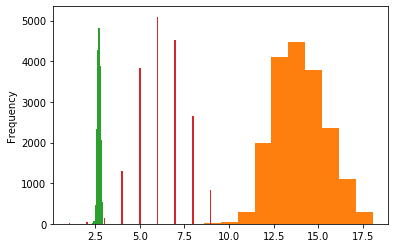

In [18]:
#df['estimate'].hist()

# df['estimate'] = np.log(df['estimate']+1)
#df['estimate'].hist()

bins = np.linspace(df['estimate'].min(), df['estimate'].max(), 10)
digitized = np.digitize(df['estimate'], bins)

tdf = pd.DataFrame(digitized, columns = ['estimate'])
pd.Series(tdf['estimate']).plot(kind='hist', bins=100) # `bins` defines the start and end points of bins

#df['misc_cost'].hist()
# df['misc_cost'] = np.log(df['misc_cost']+1)

df = df.replace([np.inf, -np.inf], np.nan)
df = df[pd.notnull(df['misc_cost'])]

#df['misc_cost'].hist()

df['bid'].hist()

# df['bid'] = np.log(df['bid']+1)
#df['bid'].hist()

#df['over/under'].hist()
df.isna().sum()

tdf = pd.DataFrame(digitized, columns = ['misc_cost'])
pd.Series(tdf['misc_cost']).plot(kind='hist', bins=100) # `bins` defines the start and end points of bins

In [19]:
df.isna().sum()
df_info = df.copy()
df_info = df_info[['county','type','bidder','winning_bidder','let_date','estimate','bid']]

county                         0
type                           0
time                           0
length                         0
check                          0
misc_cost                      0
estimate                       0
bid                            0
bidder                         0
winning_bidder                 0
id                             0
over/under                  6263
distance_from_win              0
distance_from_est              0
proj_won                       0
type_stem                      0
county_transform               0
bidder_transform               0
winning_bidder_transform       0
dtype: int64

# Text Pre-Processing

In [12]:
#Stemming Type to just base words
stemmer = PorterStemmer()
#Checking for stopwords
words = stopwords.words("english")
#Only getting text from columns
df['type_stem'] = df['type'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
df['bidder_stem'] = df['bidder'].apply(lambda x: " ".join([i for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
df['winning_bidder_stem'] = df['winning_bidder'].apply(lambda x: " ".join([i for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
df['county_stem']  = df['county'].apply(lambda x: x.lower())


# Data Encoding

,index,county,let_date,type,time,highway,length,check,misc_cost,estimate,...,distance_from_win,distance_from_est,proj_won,type_stem,bidder_stem,winning_bidder_stem,county_stem,county_transform,bidder_transform,winning_bidder_transform
0,0,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,9.615872,16.186742,...,0,-0.111182,1,emb exc str set surf mbgf,sbbi inc,sbbi inc,howard,112,551,551
1,1,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,9.615872,16.186742,...,2229,-0.058008,0,emb exc str set surf mbgf,delhur industries inc,sbbi inc,howard,112,174,551
2,2,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,9.615872,16.186742,...,6050,0.038342,0,emb exc str set surf mbgf,reece albert inc,sbbi inc,howard,112,516,551
3,3,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,9.615872,16.186742,...,7687,0.092262,0,emb exc str set surf mbgf,price construction ltd,sbbi inc,howard,112,491,551
4,4,HOWARD,2015-05-05,"EMB, EXC, STRS, SET, SURF, MBGF",311,FM 846,25.898,100000.0,9.615872,16.186742,...,11200,0.292059,0,emb exc str set surf mbgf,allen butler construction inc,sbbi inc,howard,112,29,551
5,8,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,13.122365,17.390927,...,0,-0.088706,1,widen two land rural to four lane urban,mario sinacola sons excavating inc,mario sinacola sons excavating inc,denton,60,415,415
6,9,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,13.122365,17.390927,...,318,-0.079930,0,widen two land rural to four lane urban,j d abrams l p,mario sinacola sons excavating inc,denton,60,316,415
7,10,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,13.122365,17.390927,...,1048,-0.062079,0,widen two land rural to four lane urban,haydon central llc,mario sinacola sons excavating inc,denton,60,278,415
8,11,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,13.122365,17.390927,...,1213,-0.058210,0,widen two land rural to four lane urban,austin bridge road services lp,mario sinacola sons excavating inc,denton,60,58,415
9,12,DENTON,2015-11-03,WIDEN TWO LAND RURAL TO FOUR LANE URBAN,521,FM 156,6.764,100000.0,13.122365,17.390927,...,1486,-0.051520,0,widen two land rural to four lane urban,mcm,mario sinacola sons excavating inc,denton,60,421,415


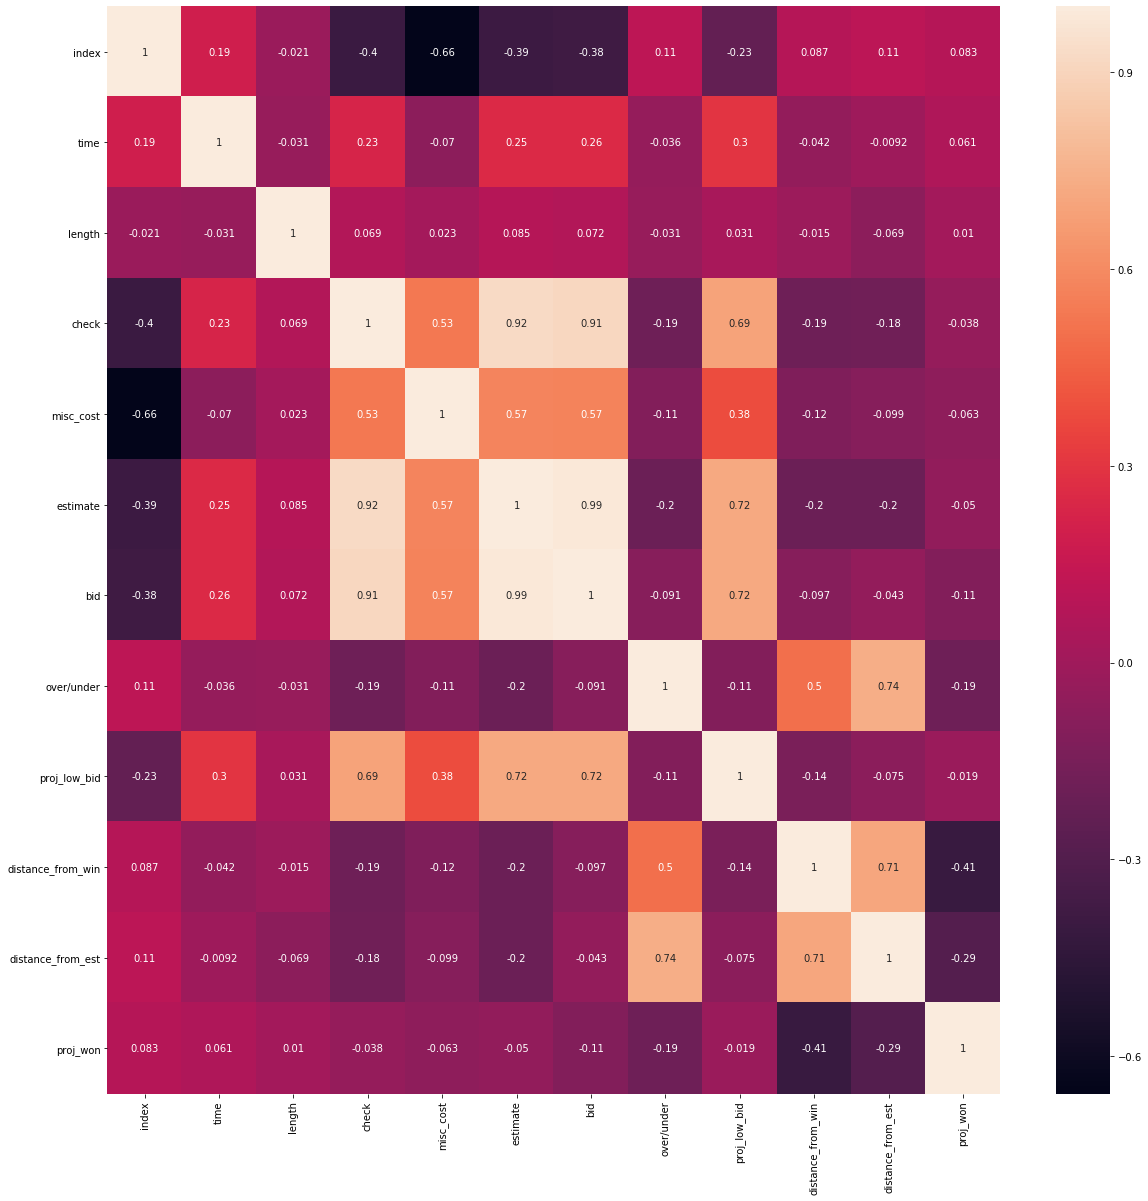

In [13]:
# scaler = preprocessing.StandardScaler()

# df[['misc_cost','estimate','length','over/under','bid','distance_from_win']] = scaler.fit_transform(df[['misc_cost','estimate','length','over/under','bid','distance_from_win']])

# df['distance_from_win'] = df['distance_from_win'].apply(lambda x: x*100000)
# df['misc_cost'] = df['misc_cost'].apply(lambda x: x*100000)
# df['estimate'] = df['estimate'].apply(lambda x: x*100000)
# df['bid'] = df['bid'].apply(lambda x: x*100000)
# df['over/under'] = df['over/under'].apply(lambda x: x*100000)
# df['length'] = df['length'].apply(lambda x: x*10000)
# df['distance_from_win'] = df['distance_from_win'].astype(int)

# df['misc_cost'] = df['misc_cost'].astype(int)
# df['estimate'] = df['estimate'].astype(int)
# df['bid'] = df['bid'].astype(int)
# df['over/under'] = df['over/under'].astype(int)
# df['length'] = df['length'].astype(int)
# df

plt.figure(figsize=(20, 20))
Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

cor_target = abs(Var_Corr["distance_from_win"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

# ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
# ohe_df = ohe.fit_transform(df[['bidder_stem','winning_bidder_stem','county']])
# # bid = pd.DataFrame(ohe.transform(df['bidder_stem']))
# # wbid = pd.DataFrame(ohe.transform(df['winning_bidder_stem']))
# # cnty = pd.DataFrame(ohe.transform(df['county']))
# df = pd.concat([df, ohe_df], axis=1)

# filename = 'ohe.sav'
# pickle.dump(ohe, open(filename, 'wb'))

le = preprocessing.LabelEncoder()
df['county_transform'] = le.fit_transform(df['county'])
le.fit(df['bidder_stem'])
df['bidder_transform'] = le.transform(df['bidder_stem'])
df['winning_bidder_transform'] = le.transform(df['winning_bidder_stem'])
#df = df.drop(['county','bidder','winning_bidder'])
df['distance_from_win'] = le.fit_transform(df['distance_from_win'])

df

# Final Data Cleaning

check                0.181580
estimate             0.202901
over/under           0.738291
distance_from_win    0.592629
distance_from_est    1.000000
proj_won             0.293530
Name: distance_from_est, dtype: float64

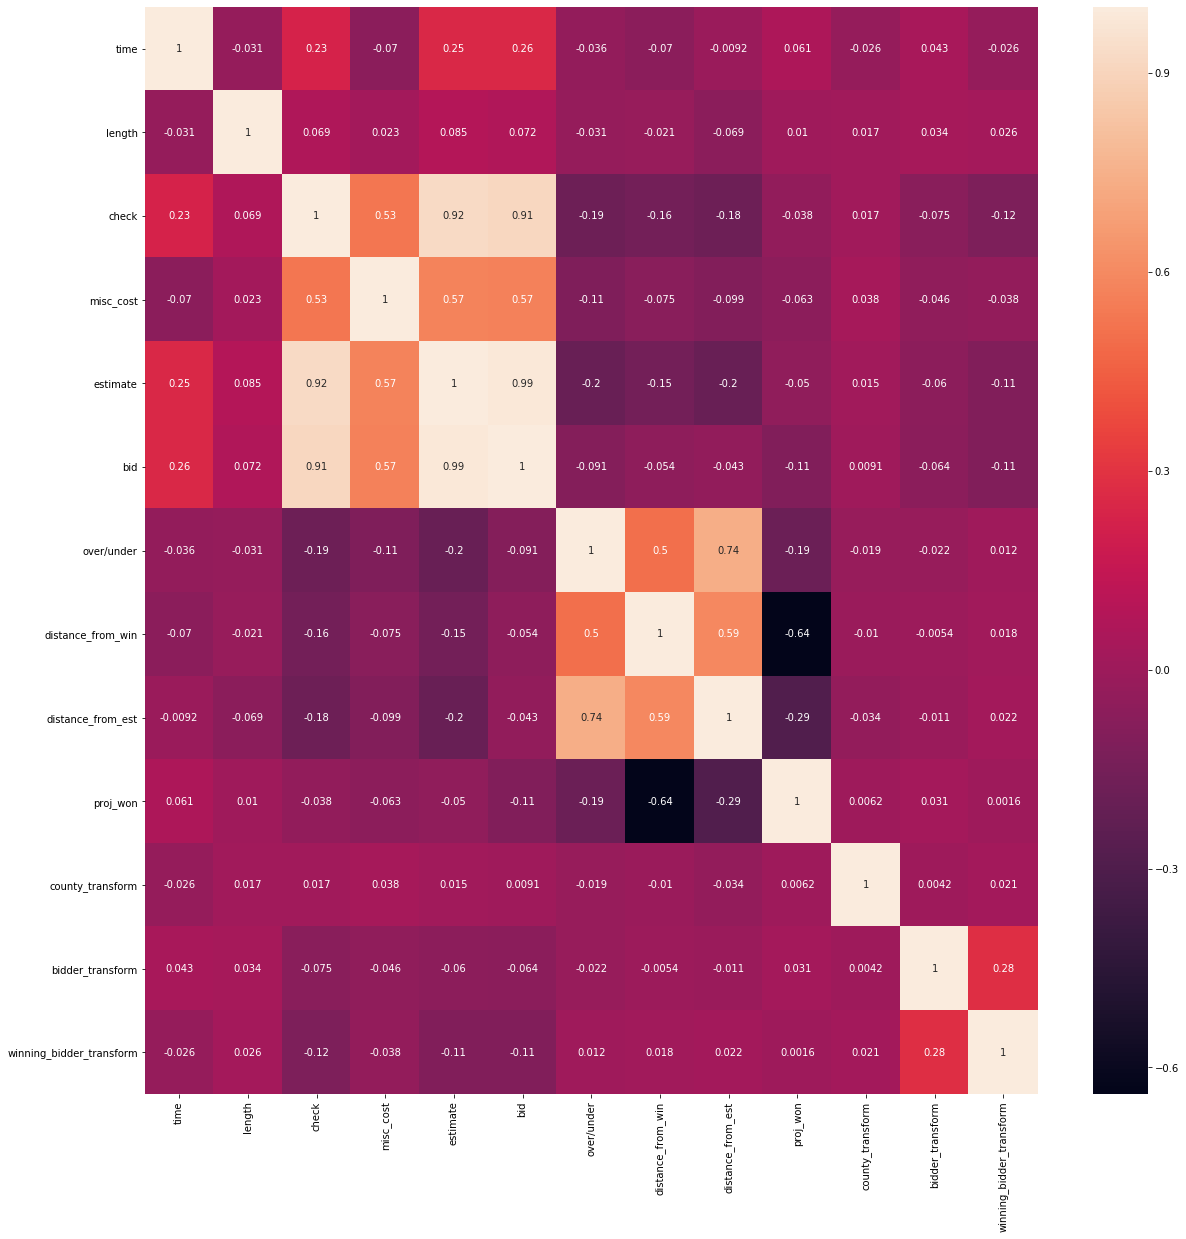

In [14]:
df = df.drop(['county_stem','bidder_stem','winning_bidder_stem','proj_low_bid'],axis = 1)

#df = df.drop(['county','bidder','winning_bidder'],axis = 1)

df = df.drop(['index','let_date','highway','date_accessed'],axis = 1)

plt.figure(figsize=(20, 20))
Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

df

cor_target = abs(Var_Corr["distance_from_est"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

# df = df.drop(['check'],axis = 1)
# df_info = df_info.drop(['level_0'],axis = 1)
# df_info
# df = df.reset_index(drop = True)
# df_info = df_info.reset_index(drop = True)

# scaler = preprocessing.MinMaxScaler()
# df[['misc_cost','estimate','length','over/under','bid','proj_low_bid']] = scaler.fit_transform(df[['misc_cost','estimate','length','over/under','bid','proj_low_bid']])

# plt.figure(figsize=(20, 20))
# Var_Corr = df.corr()
# # plot the heatmap and annotation on it
# sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)t.strftime('%Y%m%d')

In [17]:
df['estimate']

0        16.186742
1        16.186742
2        16.186742
3        16.186742
4        16.186742
5        17.390927
6        17.390927
7        17.390927
8        17.390927
9        17.390927
10       17.390927
11       17.390927
12       16.553481
13       16.553481
14       16.553481
15       16.199184
16       16.199184
17       16.199184
18       12.546291
19       12.546291
20       12.546291
21       12.546291
22       12.546291
23       16.114762
24       16.114762
25       16.114762
26       16.114762
27       16.114762
28       16.114762
29       16.114762
           ...    
18444    13.783969
18445    13.783969
18446    13.783969
18447    14.744991
18448    14.744991
18449    14.744991
18450    13.197632
18451    13.197632
18452    13.197632
18453    13.197632
18454    14.235497
18455    14.235497
18456    14.235497
18457    14.306485
18458    14.306485
18459    14.306485
18460    14.306485
18461    14.306485
18462    13.466570
18463    13.466570
18464    13.466570
18465    14.

In [ ]:
pd.to_pickle(df,'df.pkl')
pd.to_pickle(df_info,'df_info.pkl')